# Example of $EvoSim$ on 2CO*-1OH* Pt(553) configurations

### 1. Import the necessary functions
To use this notebook, installing `Joblib` is necessary.

In [1]:
import pandas as pd
from tqdm import tqdm
import multiprocessing
from joblib import Parallel, delayed
from itertools import combinations
import similarity as sim
import utility as utility
import glob
import os
import numpy as np
print("successfully loaded packages")

successfully loaded packages


### 2. Filter and load the non-isomorphic configurations
The DFT relaxed configurations are `Pt553_CO-OH/1CO-1CO-1OH-out/contcar/*POSCAR*/CONTCAR`.

First, we need to filter the non-isomorphic configurations by executing the following script in the terminal:

`python step2_postprocess_contcars.py -contcar_dir Pt553_CO-OH/1CO-1CO-1OH-out/contcar`.

This script locates the DFT relaxed configurations and use `Surfgraph` package to perform isomorphism checking.

After the execution of the above script, the non-isomorphic configurations are \
saved in the `Pt553_CO-OH/1CO-1CO-1OH-out/contcar/unique_dir/`.

This script also extract the energy information from `Pt553_CO-OH/1CO-1CO-1OH-out/contcar/*POSCAR*/OUTCAR`. \
The corresponding DFT energies are saved in the txt file: `Pt553_CO-OH/1CO-1CO-1OH-out/contcar/*POSCAR*/energies.txt` \
Thus, `OUTCAR` files can be deleted to save storage space. \
We then load these configurations for similarity calculations.

In [2]:
conf_dir = 'Pt553_CO-OH'
coverage = '1CO-1CO-1OH'
isomor_conf_dir = f'{conf_dir}/{coverage}-out/contcar/unique_dir'
path_arr_all,con_out_dict = utility.get_contcar_from_isomor_outcar(isomor_conf_dir)

### 3. Evolutionary algorithm: applying a 0.3 eV cutoff on the non-isomorphic configurations
DFT energy for each non-isomorphic configuration is saved in a csv file \
`Pt553_CO-OH/1CO-1CO-1OH-out/isomorph_dft_energy.csv`.

DFT energy for each non-isomorphic configuration output from \
the evolutionary algorithm is saved in another csv file \
`Pt553_CO-OH/1CO-1CO-1OH-out/evo_dft_energy.csv`.

In [3]:
e_cut = 0.3
df_energy = utility.get_energys(path_arr_all)
df_energy.to_csv(f'{conf_dir}/{coverage}-out/isomorph_dft_energy.csv')
energy_min = df_energy['energy'].min()
energy_df_reduced = df_energy[df_energy['energy'] <= energy_min+e_cut]
energy_df_reduced.to_csv(f'{conf_dir}/{coverage}-out/evo_dft_energy.csv')
path_arr = energy_df_reduced['conf_name'].to_numpy()

155    Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00023.POSC...
Name: conf_name, dtype: object -360.63688336


### 4. Generate configuration pairs for similarity calculations

In [4]:
compare_pairs = list(combinations(path_arr,2))

### 5. Perform similarity calculations utilizing `Joblib` parallel processing
Here, `n_jobs = -2` specifies that we are using `n_cores - 1` cpu cores. \
If one wants to use all cpu cores, one would need to set `n_jobs = -1`. \
For detailed instruction of using `joblib.Parallel`, please refer to https://joblib.readthedocs.io/en/latest/parallel.html.

The `start_atom_ele` sets element of the root atom for the Breadth-first search (BFS) \
for constructing the adjacency matrix of each chemical environment graph ($G_{chem-env}$). \
The sequence of atoms outputed from the BFS won't change the results, as we use the eigenvalues \
sorted by the magnitude.

It is highly recommended to use the surface atom element because surface atoms \
are always present in each $G_{chem-env}$. In this case, \
we use `Pt`, which is also the default setting.

The calculated pairwise similarity scores are saved in a csv file located at \
`Pt553_CO-OH/1CO-1CO-1OH-out/similarity_scores.csv` and can be accessed using `pandas`.

In [5]:
similarity_arr = Parallel(n_jobs=-2)(delayed(sim.compare_eigval_diff)(i,start_atom_ele='Pt')
                                                                       for i in tqdm(compare_pairs))
pair0_info_arr = [i[0] for i in compare_pairs]
pair1_info_arr = [i[1] for i in compare_pairs]
sim_scores_path = f'{conf_dir}/{coverage}-out/similarity_scores.csv'

results_contents_df = pd.DataFrame({'config1':pair0_info_arr,
                                    'config2':pair1_info_arr,
                                    'similarity':similarity_arr})
                                    # 'sim_ad_chain':sim_ad_chain_info_arr})
results_contents_df.sort_values('similarity').to_csv(sim_scores_path)

100%|██████████| 4005/4005 [04:29<00:00, 14.84it/s]


### 6. Analyze the similarity score clusters
It is a good pratice to analyze the average energy difference among the configuration pairs within \
each of the top four similarity score clusters and decide which cluster to be selected for \
highly similar configuration removal.

Pt553_CO-OH summary:
1 most similar cluster: mean energy diff=0.0305791163888895 eV,std=0.022625892272254703 eV, N=36
2 most similar cluster: mean energy diff=0.10471921999998131 eV,std=0.02029346445962764 eV, N=5
3 most similar cluster: mean energy diff=0.11151134857142811 eV,std=0.036781427912089375 eV, N=7
4 most similar cluster: mean energy diff=0.03809676456522173 eV,std=0.03561723228267529 eV, N=46


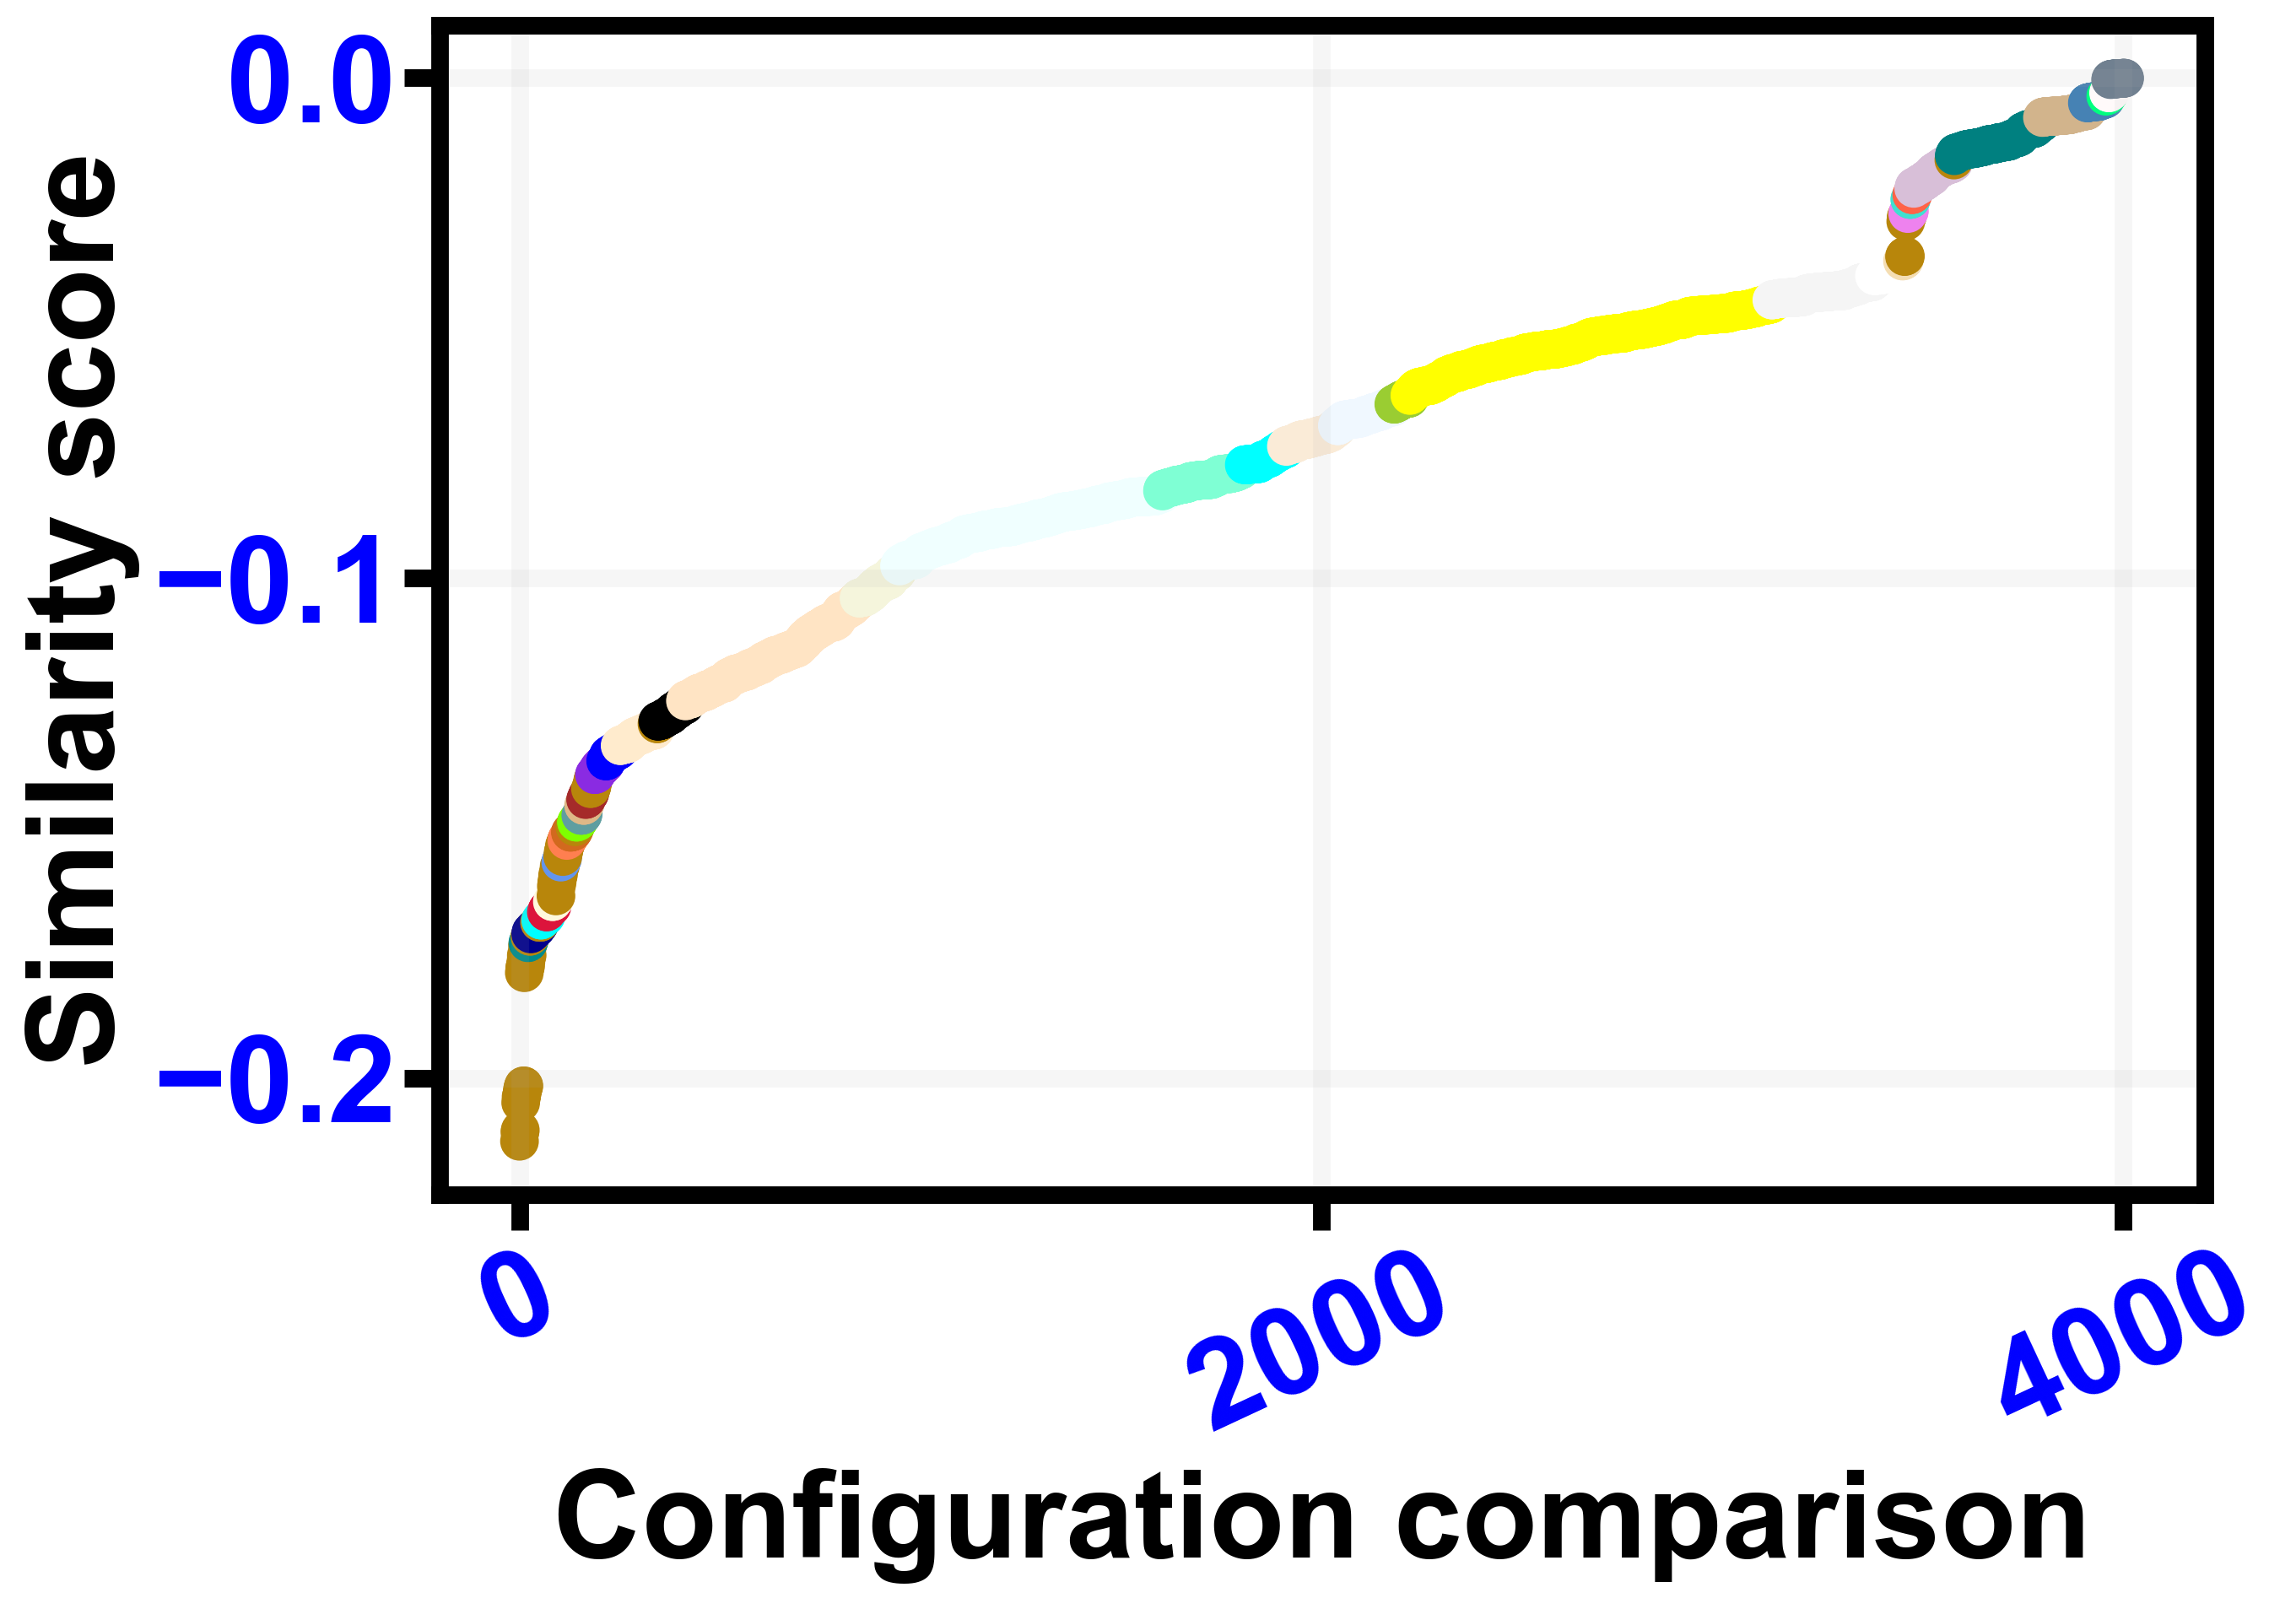

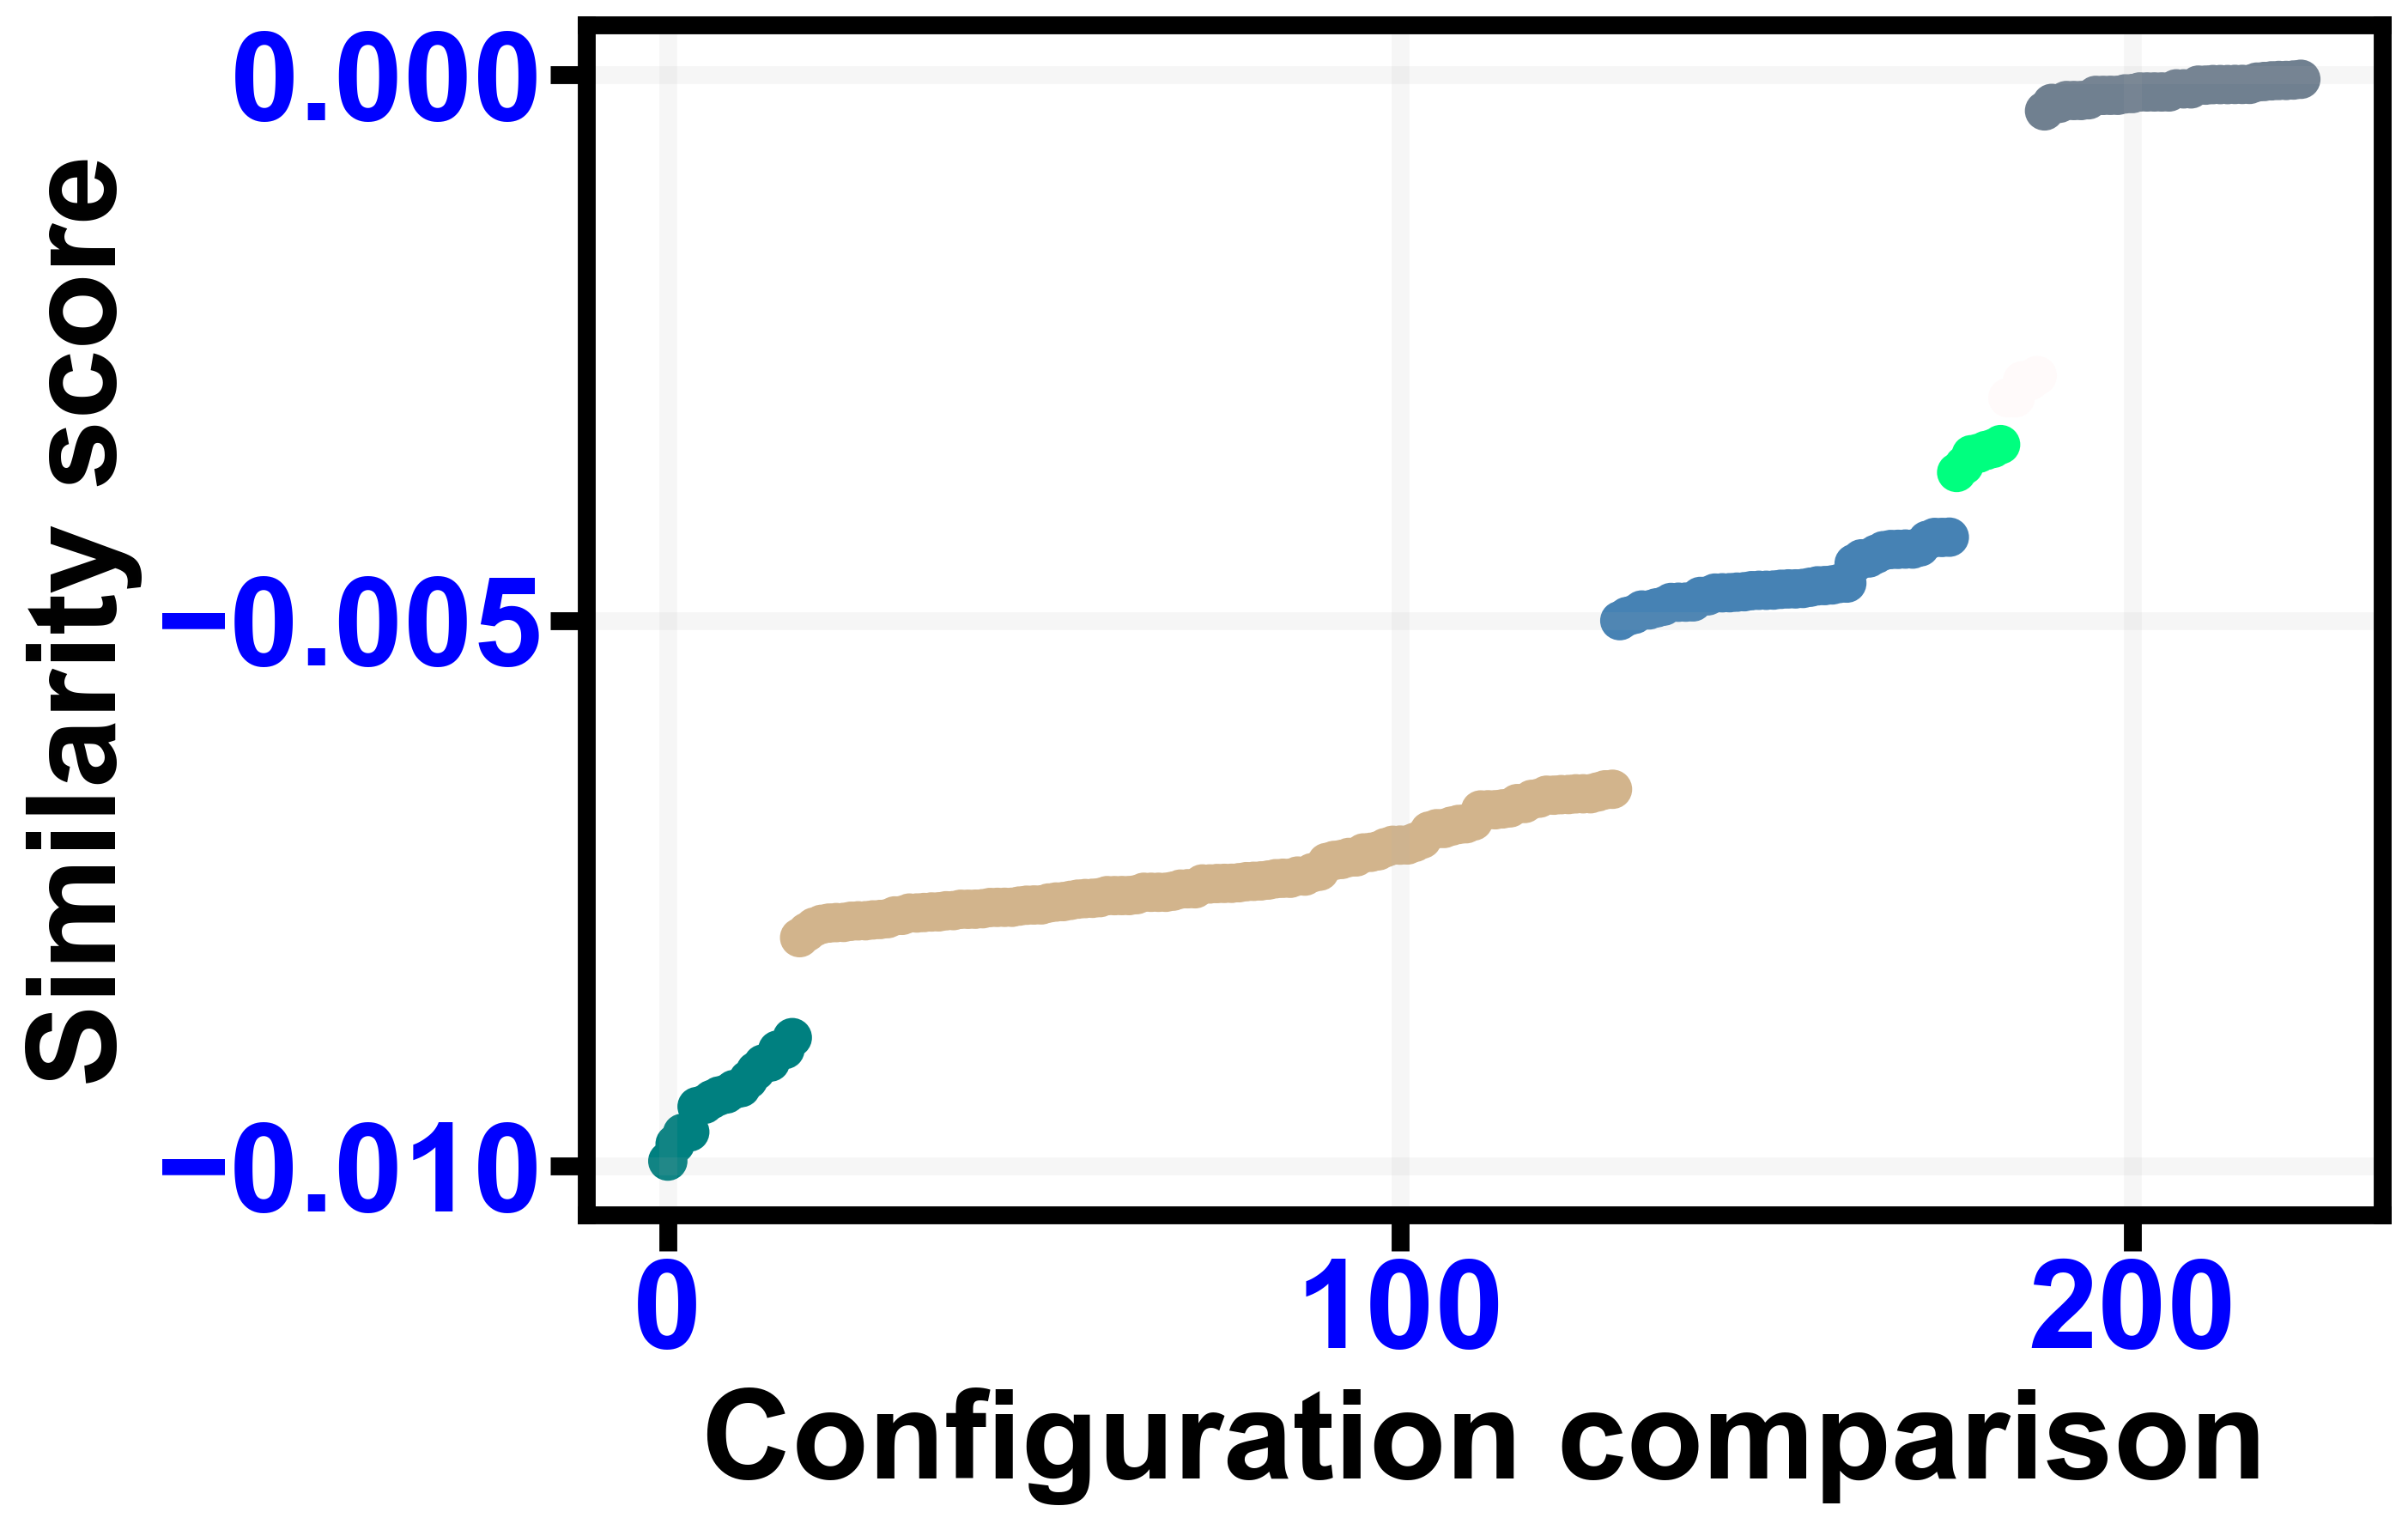

In [6]:
def get_abs_e_diff_from_sim_cluster(clustered_df,cluster_label):
    abs_diff_arr = []
    df = clustered_df[clustered_df['cluster']==cluster_label]
    for index, row in df.iterrows():
        conf1_path = row['config1']
        conf2_path = row['config2']
        
        conf1_e = utility.get_energy(glob.glob(os.path.dirname(conf1_path)+'/energies.txt')[0])
        conf2_e = utility.get_energy(glob.glob(os.path.dirname(conf2_path)+'/energies.txt')[0])
        abs_diff = abs(conf1_e-conf2_e)
        abs_diff_arr.append(abs_diff)
    return abs_diff_arr

cluster_conf_df = utility.cluster_detect(sim_scores_path)
print(f'{conf_dir} summary:')
cluster_idx_arr_all = utility.get_sorted_cluster_idx_arr(cluster_conf_df)
cluster_idx_arr = [1,2,3,4]
for idx in cluster_idx_arr:
    abs_diff_arr = get_abs_e_diff_from_sim_cluster(cluster_conf_df,cluster_idx_arr_all[-idx])
    print(f'{idx} most similar cluster: mean energy diff={np.average(abs_diff_arr)} eV,std={np.std(abs_diff_arr)} eV, N={len(abs_diff_arr)}')

utility.ploting(cluster_conf_df)
utility.ploting(cluster_conf_df,interval=(-0.01,0))

### 7. Remove highly similar configurations
Here, we use the top two clusters for highly similar configurations removal and obtain the unique configurations. \
We then save their initial configurations, configurations before DFT relaxation (`Pt553_CO-OH/1CO-1CO-1OH-out/unique_dir/*`), \
into `Pt553_CO-OH/1CO-1CO-1OH-out/unique_unique/`.

DFT energy of each unique configurations are saved is a csv file located at `Pt553_CO-OH/1CO-1CO-1OH-out/unique_unique_dft_energy.csv`.

In [7]:
unique_conf_arr = utility.get_unique_evolution(sim_scores_path,e_cutoff=e_cut,n_cluster=2,show_struc=False)
print('conf left by similarity',len(unique_conf_arr))
print(unique_conf_arr,len(unique_conf_arr))
df_energy = utility.get_energys(unique_conf_arr)
df_energy.to_csv(f'{conf_dir}/{coverage}-out/unique_unique_dft_energy.csv')
unique_init_conf = utility.make_unique_dir(unique_conf_arr,'unique_unique')

2    Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00023.POSC...
Name: conf_name, dtype: object -360.63688336
['Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00023.POSCAR_all_sites/CONTCAR'
 'Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00473.POSCAR_all_sites/CONTCAR'
 'Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00546.POSCAR_all_sites/CONTCAR'
 'Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00398.POSCAR_all_sites/CONTCAR'
 'Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00265.POSCAR_all_sites/CONTCAR'
 'Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00542.POSCAR_all_sites/CONTCAR'
 'Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00261.POSCAR_all_sites/CONTCAR'
 'Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00249.POSCAR_all_sites/CONTCAR'
 'Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00483.POSCAR_all_sites/CONTCAR'
 'Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00453.POSCAR_all_sites/CONTCAR'
 'Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00349.POSCAR_all_sites/CONTCAR'
 'Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00124.POSCAR_all_sites/CONTCAR'
 'Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00076.POSCAR_all_sites

100%|██████████| 89/89 [00:00<00:00, 114.11it/s]

conf left by similarity 58
['Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00017.POSCAR_all_sites/CONTCAR', 'Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00023.POSCAR_all_sites/CONTCAR', 'Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00034.POSCAR_all_sites/CONTCAR', 'Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00038.POSCAR_all_sites/CONTCAR', 'Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00057.POSCAR_all_sites/CONTCAR', 'Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00076.POSCAR_all_sites/CONTCAR', 'Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00083.POSCAR_all_sites/CONTCAR', 'Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00085.POSCAR_all_sites/CONTCAR', 'Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00102.POSCAR_all_sites/CONTCAR', 'Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00109.POSCAR_all_sites/CONTCAR', 'Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00115.POSCAR_all_sites/CONTCAR', 'Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00124.POSCAR_all_sites/CONTCAR', 'Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00131.POSCAR_all_sites/CONTCAR', 'Pt553_CO-OH/1CO-1CO-1OH-out/contcar/00135.POSCAR_all_sites/CO

### 8. Add another adsorbate to these unique configurations to achieve a higher coverage.
In the end, we execute the following script in the terminal for adding an OH* to all the unique 2CO*-1OH* configurations \
to achieve the 2CO*-2OH* coverage.

`python step1_get_init_conf.py -ad_file Pt553_CO-OH/OH.horizontal.POSCAR -conf_dir 'Pt553_CO-OH/1CO-1CO-1OH-out/unique_unique/*' --stepped`

The generated 2CO*-2OH* configurations are saved in the `Pt553_CO-OH/1CO-1CO-1OH-1OH-out/unique_dir/`. \
`Pt553_CO-OH/1CO-1CO-1OH-1OH-out/contcar/*POSCAR*/` are the directories for performing DFT calculation for each configuration. \
The `--stepped` flag tells the script that we are working with a stepped surface. If one is working with a terrace surface, then this \
flag won't be needed.

By executing the above script, for each 2CO*-1OH* unique configurations, multiple configurations will be generated, in which \
each configuration corresponds to placing this additional OH* on an avalilable top site on the surface.


### Notes for `step1_get_init_conf.py`

It should be note that `step1_get_init_conf.py` is written in the way that only works on the directory structure in this example, \
meaning that `step1_get_init_conf.py` can only be execute at the same directory as the `Pt553_CO-OH/`, and the 2CO-1OH unique configurations \
have to be saved at a directory under `Pt553_CO-OH/1CO-1CO-1OH-out/`.

If one wants to place an adsorbate, say CO, on an empty surface, say Pt(553), one would need to place the surface structure file under the directory \
that one wants the 1CO configurations located. As an example, executing

`python step1_get_init_conf.py -ad_file Pt553_CO-OH/CO.POSCAR -conf_dir 'Pt553_CO-OH/POSCAR_Pt553' --stepped`

would generate a directory `Pt553_CO-OH/1CO-out`, which share the same directory structure as 2CO-1OH* and 2CO-2OH* cases.